# About this Notebook

This notebook provides code to partially reproduce the velocity map generation method from the OpenFWI dataset, opening up possibilities for data augmentation.

# Introduction

Appendix B of the OpenFWI paper ([Arxiv](https://arxiv.org/abs/2111.02926)) describes the data generation method. In summary, the process seems to be as follows:

1.  Create velocity maps.
2.  Simulate seismic waves based on the velocity maps (forward modeling).

Regarding forward modeling, there were challenges, such as the Python code used for generation not being publicly available. However, [Jaewook's Notebook](https://www.kaggle.com/code/jaewook704/waveform-inversion-vel-to-seis) and its improved version, [Manato1fg's Notebook](https://www.kaggle.com/code/manatoyo/improved-vel-to-seis), have successfully reproduced the dataset with high accuracy. Furthermore, a differentiable forward model implemented with CUDA is also available ([lhwcv's discussion](https://www.kaggle.com/competitions/waveform-inversion/discussion/585236)).

However, it seems that the process of creating the velocity maps, as described in the paper, has not been explored in depth.

# Why Velocity Map Generation is Important

## Some datasets are difficult to train on

As seen in [Bartley](https://www.kaggle.com/brendanartley)'s [CV analysis](https://www.kaggle.com/competitions/waveform-inversion/discussion/582785), the errors for `CurveFault_B`, `CurveVel_B`, `FlatFault_B`, `Style_A`, and `Style_B` are considerably larger compared to other datasets. This issue could potentially be addressed through data augmentation.

## The Public LB likely contains a higher proportion of difficult datasets than the training data

The phenomenon of Public LB scores being worse than CV scores has been observed by many participants. This is believed to be because the proportion of "difficult" datasets is higher in the Public LB data compared to the training data.

This trend may continue in the Private LB, creating a significant need for augmenting these difficult datasets.

# How Velocity Maps are Generated

Appendix B (Page 16) of the OpenFWI paper ([Arxiv](https://arxiv.org/abs/2111.02926)) roughly describes how the velocity maps are generated.
To quote the paper directly, the process is:

1.  Create a flat, layered map (with random layer thicknesses) and use it as the initial model, $c_0$.
2.  Recursively apply equation (2) for the `VelFamily` and equation (3) for the `FaultFamily`.

$$ c_i(x, y) = c_{i-1}(x, a_i \sin(2\pi k_i x)); \quad i > 0, \tag{2}$$

$$ c_i(x, y) = 
\begin{cases} 
c_0(x + s_i, a_i \sin(2\pi k_i x) + s'_i), & y \ge f_i(x) \\ 
c_{i-1}(x, y), & y < f_i(x) 
\end{cases}
; \quad i > 0, \tag 3 $$

However, the distributions from which the random parameters $s_i, a_i, s'_i, f_i(x)$ are chosen are not disclosed.

This raises some questions. In equation (2), shouldn't the term $c_{i-1}(x, a_i \sin(2\pi k_i x))$ actually be $c_{i-1}(x, y + a_i \sin(2\pi k_i x))$?

Similarly, in equation (3), shouldn't the term be $c_0(x + s_i, y + a_i \sin(2\pi k_i x) + s'_i)$?

Furthermore, equation (3) only applies the operation for $y \ge f_i(x)$. When plotted, this means the transformation is only applied *below* the line $f_i(x)$. Is this intended? It wouldn't be surprising if there were cases where the transformation should also be applied *above* the line.

Hereinafter, we will consider these modifications, which we'll refer to as Equation A and Equation B.

$$ c_i(x, y) = c_{i-1}(x, y + a_i \sin(2\pi k_i x)); \quad i > 0, \tag{A}$$

$$ c_i(x, y) = 
\begin{cases} 
c_0(x + s_i, y + a_i \sin(2\pi k_i x) + s'_i), & y \ge f_i(x) \\ 
c_{i-1}(x, y), & y < f_i(x) 
\end{cases}
; \quad i > 0, \tag B $$

# (Ja) このノートブックについて

OpenFWIのデータセットにおける速度マップの生成方法を部分的に再現するコードを提供するとともに、
データセット拡張の可能性を切り開きます。

# はじめに

OpenFWIの論文([Arxiv](https://arxiv.org/abs/2111.02926))のAppendixのBでは、データの生成方法について言及されています。　その内容を要約すると、

1. 速度マップを作る
2. 速度マップを元に地震波のシミュレーションをする(forward modeling)

という流れで行われているようです。
Forwardモデリングについては、生成に使われたPythonコードが公開されていないなどの問題がありましたが、[Jaewook's Notebook](https://www.kaggle.com/code/jaewook704/waveform-inversion-vel-to-seis) や、それを改良した [Manato1fg's Notebook](https://www.kaggle.com/code/manatoyo/improved-vel-to-seis)が十分に高い精度でデータセットを再現できています。更には、CUDAを使って実装した微分可能なフォワードモデルもあります。[lhwcv's discussion](https://www.kaggle.com/competitions/waveform-inversion/discussion/585236)

しかし、論文中の速度マップを作る工程についての探求はあまりされていないようです。

# 速度マップ生成が重要である理由

## なかなか学習しきれないデータセットがある

[Bartley](https://www.kaggle.com/brendanartley)の[CV](https://www.kaggle.com/competitions/waveform-inversion/discussion/582785)
をみても、CurveFault_B,CurveVel_B,FlatFault_B, Style_A, Style_Bでの誤差が他のデータセットに比べてかなり大きくなっています。　これらは、データセットの拡張によって解決できる可能性があります。

## 訓練データに比べてPublicLBには難しいデータセットが多く含まれている(と思われる)

CVに比べてPublic LBの結果が悪くなることは多くの人で再現されており、これは難しいデータセットの比率が訓練データに比べてPublic LBのデータのほうが多いからだと考えられています。

この傾向がPrivate LBでも続く可能性はあり、難しいデータセットの拡張の需要が十分にあります。

# 速度マップ生成がどのように行われているか

OpenFWIの論文([Arxiv](https://arxiv.org/abs/2111.02926))のAppendixのB (Page 16)

に速度マップの生成方法が大まかに書かれています。
論文の表現をそのまま使うと、

1. 平坦な層状のマップ(層の厚みはランダム)を作り、それを初期解とする
2. VelFamilyには(2)を、Fault Familyには(3)を再帰的に適用する。

$$ c_i(x, y) = c_{i-1}(x, a_i \sin(2\pi k_i x)); \quad i > 0, \tag{2}$$

$$ c_i(x, y) = 
\begin{cases} 
c_0(x + s_i, a_i \sin(2\pi k_i x) + s'_i), & y \ge f_i(x) \\ 
c_{i-1}(x, y), & y < f_i(x) 
\end{cases}
; \quad i > 0, \tag 3 $$

とあります。　しかし、ランダムに選ばれる $s_i, a_i, s'_i, f_i(x)$ の選ばれる分布などは公開されていません。

これには、不可解な点があります。 (2)式の $c_{i-1}(x, a_i \sin(2\pi k_i x) $ は $c_{i_i}(x, y + a_i \sin(2\pi k_i x) $ ではないでしょうか？

同じように、 (3)式も $ c_0(x + s_i, y + a_i \sin(2 \pi k_i x) + s'_i) $ であるべきではないでしょうか？

また、(B)の式は $ y \ge f_i(x) $　にのみ操作を行っています。これは、プロットしたときの図でいうと、直線の下側にのみ変換を与えていることになりますが、これでいいのでしょうか？直線の上側にも変換を行う場合があってもおかしくないでしょう。

以下、この修正を施した式A,Bについて考えていきます。

$$ c_i(x, y) = c_{i-1}(x, y + a_i \sin(2\pi k_i x)); \quad i > 0, \tag{A}$$

$$ c_i(x, y) = 
\begin{cases} 
c_0(x + s_i, y + a_i \sin(2\pi k_i x) + s'_i), & y \ge f_i(x) \\ 
c_{i-1}(x, y), & y < f_i(x) 
\end{cases}
; \quad i > 0, \tag B $$



In [1]:
# plotting utils
import numpy as np
import matplotlib.pyplot as plt

# for plotting
def plot_vel(vel_arr: np.ndarray, title: str = "Velocity Model"):
    import matplotlib.pyplot as plt
    assert vel_arr.ndim == 2
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(vel_arr, aspect="auto", cmap="seismic", vmin=1500, vmax=4500)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    plt.colorbar(im)
    plt.show()
    plt.close(fig)

In [2]:
# Transformation corresponding to Equation (A)
def transform_curve(c: np.ndarray, a: float, k: float) -> np.ndarray:
    """
    Transformation based on the formula: c_i(x,y) = c_{i-1}(x, y + a*sin(2πkx)).

    Args:
        c (np.ndarray): Input 2D velocity model, with shape (z, x).
        a (float): Amplitude of the distortion in pixels. A positive value has the effect of lifting the layers upwards.
        k (float): Wavenumber of the distortion. This corresponds to the number of waves across the entire width of the image.

    Returns:
        np.ndarray: The transformed 2D velocity model.
    """
    assert c.ndim == 2
    ZB, XB = c.shape

    ret: np.ndarray = np.zeros_like(c)
    
    # Set the value of each pixel in the output image based on the source z-coordinate.
    for x in range(XB):
        for z in range(ZB):
            # Calculate the source z-coordinate.
            source_z: float = z + a * np.sin(2 * np.pi * k * (x / (XB - 1)))
            from_z: int = int(source_z)

            # Clamp the coordinate to be within the image bounds.
            if from_z < 0:
                from_z = 0
            elif from_z >= ZB:
                from_z = ZB - 1

            ret[z, x] = c[from_z, x]
    return ret

# Replicating CurveVel using Equation A

We can approximately replicate the `CurveVel` dataset using this equation.

# (Ja)式Aを使ったCurveVelの再現

CurveVelを概ね再現することができます

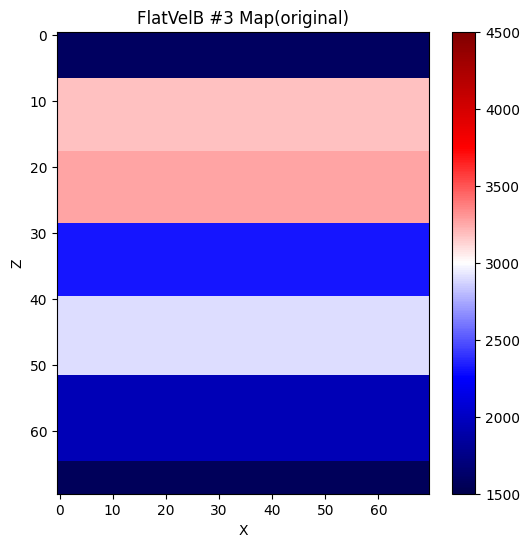

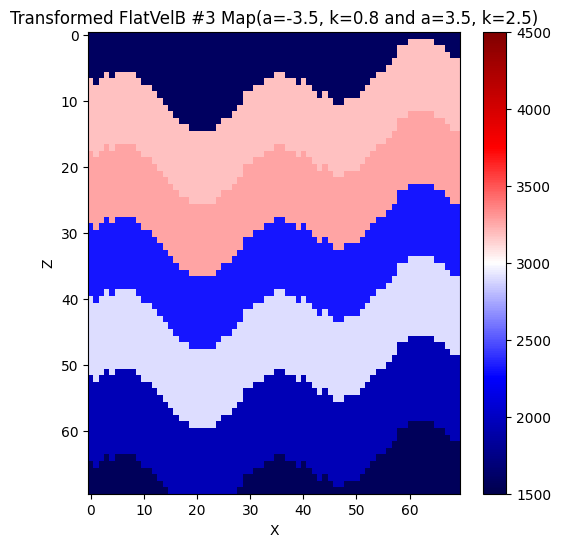

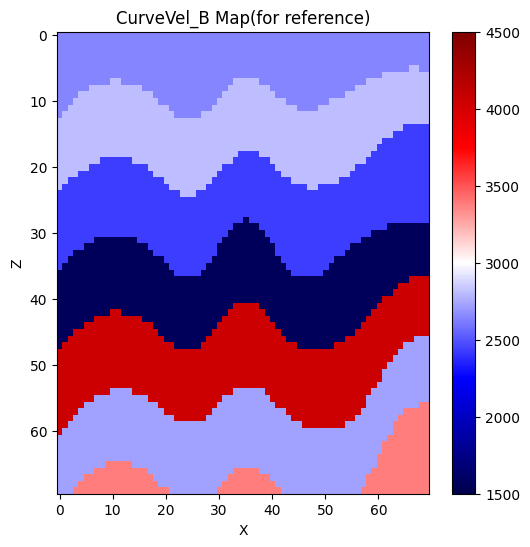

In [3]:
fvbs = np.load("/kaggle/input/waveform-inversion/train_samples/FlatVel_B/model/model1.npy")
cvbs = np.load("/kaggle/input/waveform-inversion/train_samples/CurveVel_B/model/model1.npy")
 
vel = fvbs[2][0] # shape: (70, 70)
plot_vel(vel, "FlatVelB #3 Map(original)")
plot_vel(transform_curve(transform_curve(vel, a=-3.5, k=0.8), a=3.5, k=2.5) , "Transformed FlatVelB #3 Map(a=-3.5, k=0.8 and a=3.5, k=2.5)")

plot_vel(cvbs[3][0], "CurveVel_B Map(for reference)")

# Replicating CurveFault_B using Equation B

To be honest, I don't feel this reproduces it very well. Unlike the case with `CurveVel`, there are as many as seven parameters. Moreover, observing the actual `CurveFault_B` data, it seems that the transformation has been applied multiple times.

Incidentally, it's likely that `FlatFault` can be reproduced by setting `a=0`.

# (ja)式Bを使ったCurveFault_Bの再現

正直に言って、あまり再現出来ている気がしません。Curve Velを再現するときと違い、パラメータが7つもある上に、実際のCFBを見ると変形がかなりの回数行われているようにみえます。

ちなみに、FlatFaultの再現はa=0とすることでできると思われます。

In [4]:
# Transformation corresponding to Equation B
def transform_fault(c: np.ndarray, a: float, k: float, s: float, s2: float, f_a: float, f_b: float, apply_down_side: bool=True) -> np.ndarray:
    """
    Applies a fault-like transformation based on a dividing line f(x).

    Let f(x) be the fault line, defined as: f(x) = f_a * x + f_b.
    The transformation is based on the formula:
    c_i(x,y) = c_{i-1}(x + s, y + a * sin(2πkx) + s')  (if condition is met)
    c_i(x,y) = c_{i-1}(x, y)                         (otherwise)

    Args:
        c (np.ndarray): Input 2D velocity model, with shape (z, x).
        a (float): Amplitude of the distortion in pixels. A positive value lifts the layers upwards.
        k (float): Wavenumber of the distortion. Corresponds to the number of waves across the image width.
        s (float): Shift amount in the x-direction (in pixels).
        s2 (float): Shift amount in the y-direction (in pixels), corresponding to s' in the paper.
        f_a (float): Slope of the fault line f(x).
        f_b (float): Y-intercept of the fault line f(x).
        apply_down_side (bool):
            If True, applies the transformation to the region y >= f(x) (the area below the line).
            If False, applies the transformation to the region y < f(x) (the area above the line).
    """
    assert c.ndim == 2
    ZB, XB = c.shape

    ret: np.ndarray = np.zeros_like(c)
    
    # Iterate through each pixel of the output image.
    for x in range(XB):
        for z in range(ZB):
            # Calculate the fault line's position at the current x.
            f_x: float = f_a * x + f_b
            
            # Determine if the current pixel (z, x) is in the region to be transformed.
            should_apply = (z >= f_x and apply_down_side) or (z < f_x and not apply_down_side)

            if should_apply:
                # Calculate the source coordinates from which to pull the velocity value.
                source_z: float = z + a * np.sin(2 * np.pi * k * (x / (XB - 1))) + s2
                source_x: float = x + s

                from_z: int = int(source_z)
                from_x: int = int(source_x)

                # Clamp the coordinates to be within the image bounds.
                from_z = max(0, from_z)
                from_z = min(ZB - 1, from_z)
                from_x = max(0, from_x)
                from_x = min(XB - 1, from_x)

                ret[z, x] = c[from_z, from_x]
            else:
                # If not in the transformed region, keep the original value.
                ret[z, x] = c[z, x]
    return ret

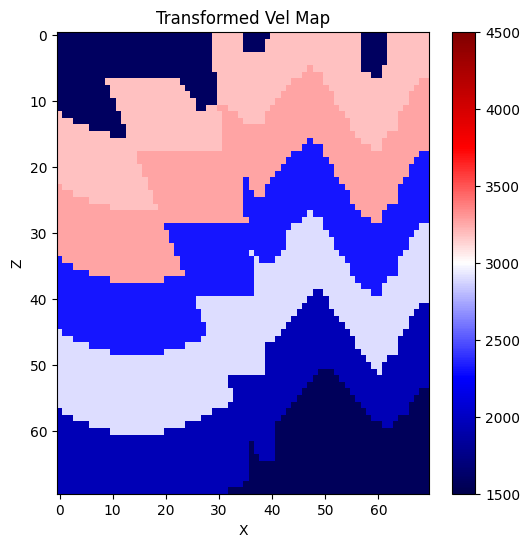

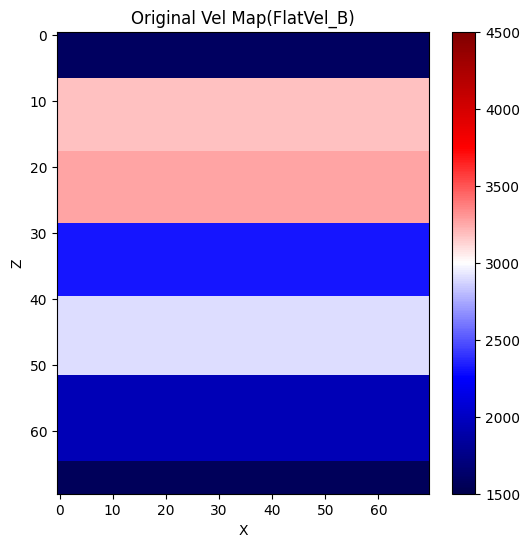

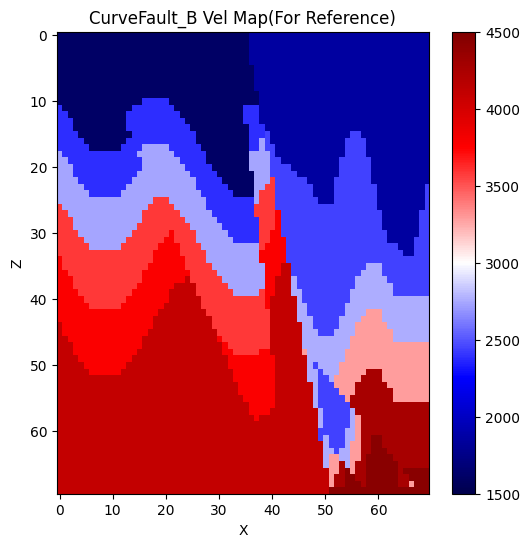

In [5]:
cfbs = np.load("/kaggle/input/waveform-inversion/train_samples/CurveFault_B/vel6_1_0.npy")

arr = fvbs[2][0]
arr = transform_fault(arr, a=4.2, k=3.1, s=15, s2=10, f_a=6.5, f_b=-200, apply_down_side=False)
arr = transform_fault(arr, a=2.4, k=2.1, s=2, s2=-2, f_a=1.2, f_b=-20, apply_down_side=False)
arr = transform_fault(arr, a=-3.5, k=1.2, s=5, s2=-5, f_a=2.0, f_b=-10, apply_down_side=True)
plot_vel(arr, title="Transformed Vel Map")
plot_vel(fvbs[2][0], title="Original Vel Map(FlatVel_B)")
plot_vel(cfbs[0][0], title="CurveFault_B Vel Map(For Reference)")


# Future Work

The code published in this notebook demonstrated how to transform an existing flat map into a curved one. However, to achieve full data augmentation, several challenges remain:

1.  **Unknown generation method for flat maps:** The process for creating the initial flat maps is not specified. This includes details like the number of layers, their thicknesses, and whether there is a specific relationship between velocity and depth.

2.  **Unknown details of Curve generation:** The specifics of how the `Curve` families are generated are unclear. This includes the distributions from which parameters `a` and `k` are sampled, and the number of times the transformation is applied recursively.

3.  **Unknown details of Fault generation:** Similarly, the specifics for generating the `Fault` family are unclear. This includes the distributions for sampling the parameters `a, k, s, s'`, and the parameters defining the fault line `f_i(x)`. It's also unknown how many times this transformation is composed.

4.  **Style Transfer methods not yet implemented:** The transformation methods used for `Style_A` and `Style_B`, which likely involve style transfer, have not been implemented yet.

Regarding point 2, it might be possible to reverse-engineer the wave components of each velocity map using techniques like the Fourier Transform. This could allow us to estimate the underlying distributions of the parameters.

# (Ja)今後の展望

今回のノートブックで公開したコードは、Flatなマップがある状態で、それをCurveに変形するものでした。　完全なデータセット拡張のためには、以下のような困難があります。


1. Flatなマップの生成方法が不明(層の幅、数、速度と深さの対応関係を作るかどうかなど)
2. Curveの生成方法の詳細が不明(a,k,sはどのような分布からサンプリングするのか。変換の合成は何回やるのか)
3. Faultの生成方法の詳細が不明(a,k,s,s',f_a,f_bをどのような分布からサンプリングするのか。変換の合成は何回やるのか)
4. Style_A,Style_BなどのStyleTransferを使った変形のやり方はまだ実装できていない

2については、おそらくフーリエ変換などを使うと各速度マップについてどのような波から出来ているかの逆算はできそうなので、分布を得ることができそうです。
